Test rebinning of 3D density field

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from scipy import ndimage
import scipy.interpolate
from scipy import stats

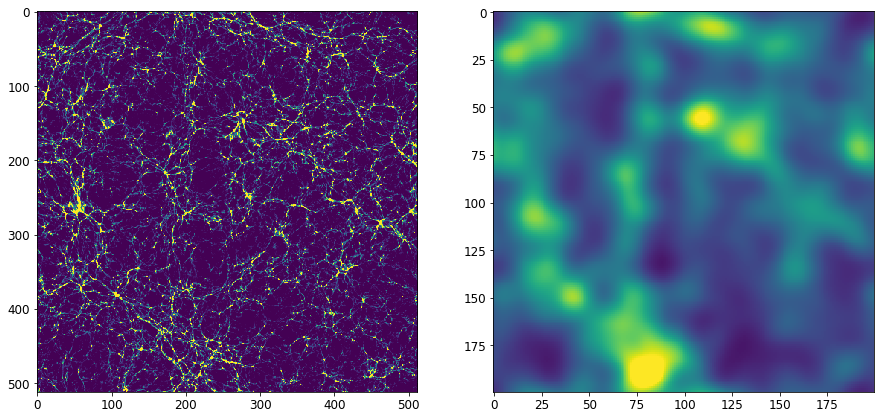

In [2]:
Lbox = 100.
gauss_sm = 3.
nbin_in = 512

dx_in = Lbox/nbin_in
dm_nyx_fil = '/Users/kheegan/lya/3d_recon/preheating/nyx1000_512.npy'
dm_nyx_in = np.load(dm_nyx_fil)

nbin=200
dx = Lbox/nbin
sm_tmp = np.sqrt(gauss_sm**2 - dx**2)
dm_in_sm = ndimage.gaussian_filter(dm_nyx_in, gauss_sm/Lbox*512, mode='wrap')
dm_nyx = ndimage.zoom(dm_in_sm, nbin/nbin_in)
#dm_nyx = ndimage.gaussian_filter(dm_nyx, sm_tmp/dx, mode='wrap')

xbinsn = np.linspace(0, Lbox, num=nbin+1)
ybinsn = np.linspace(0, Lbox, num=nbin+1)
zbinsn = np.linspace(0, Lbox, num=nbin+1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

ax1.imshow(dm_nyx_in[:,:,0],vmin=0.3,vmax=5)
#ax1.pcolormesh(X, Y, fslice, cmap='jet_r', vmin=-0.25, vmax=0.25)
#ax1.set_aspect('equal')

ax2.imshow(dm_nyx[:,:,0], vmin=0.3,vmax=2)
#ax2.pcolormesh(X, Y, dslice, cmap='plasma', vmin=0.3, vmax=2)
#ax2.set_aspect('equal')

plt.show()

For the 2Mpc/h version, we directly rebin from the smoothed full-resolution box.

Text(0.5, 1.0, '2Mpc/h binning')

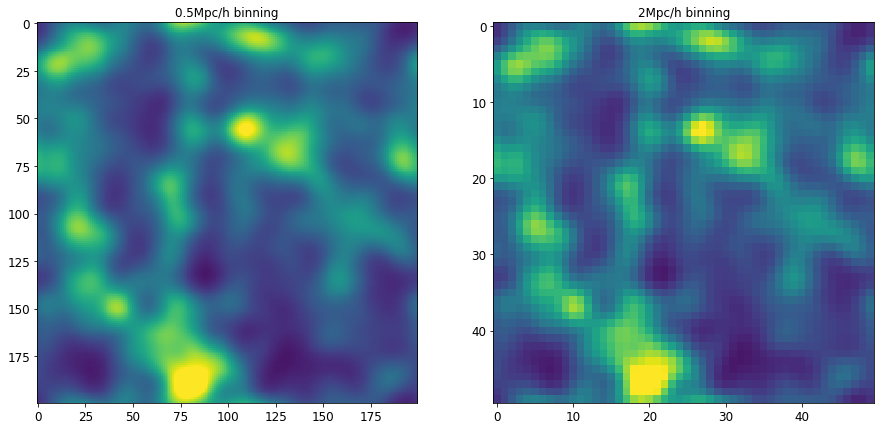

In [3]:
# Rebin Nyx DM field to 2Mpc/h bins
nbincoarse = 50
dx_c = Lbox/nbincoarse

#sm2 = 2. # This is the smoothing that is needed before rebinning
#sm_tmp = np.sqrt(gauss_sm**2 - sm2**2)

dm_coarse = ndimage.zoom(dm_in_sm, nbincoarse/nbin_in)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

slicedm = dm_nyx[:,:,0]
ax1.imshow(slicedm, vmin=0.3,vmax=2)
ax1.set_title('0.5Mpc/h binning')

ax2.imshow(dm_coarse[:,:,0], vmin=0.3,vmax=2)
ax2.set_title('2Mpc/h binning')

Now we test the interpolation of the coarse 2Mpc/h box into the 0.5Mpc/h bins

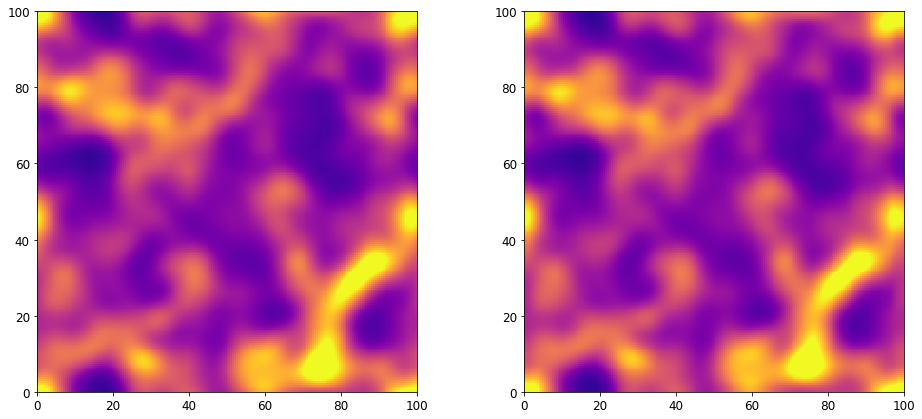

In [4]:
# Interpolate the coarse 2Mpc/h grid to the obtain fine grid with 0.5Mpc/h binning

xcen = xbinsn[0:-1]+(xbinsn[1]-xbinsn[0])/2.
ycen = ybinsn[0:-1]+(ybinsn[1]-ybinsn[0])/2.
zcen = zbinsn[0:-1]+(zbinsn[1]-zbinsn[0])/2.

xgdm = np.linspace(0.,Lbox, nbincoarse+1)
dx_c = (xgdm[1]- xgdm[0])/2.
xgdm = xgdm[0:-1] + dx_c
ygdm = np.linspace(0.,Lbox, nbincoarse+1)
ygdm = ygdm[0:-1] + dx_c
zgdm = np.linspace(0.,Lbox, nbincoarse+1)
zgdm = zgdm[0:-1] + dx_c

ix2c = (xcen - xgdm[0])/dx_c*dx
iy2c = (ycen - ygdm[0])/dx_c*dx
iz2c = (zcen - ygdm[0])/dx_c*dx

xgfine, ygfine, zgfine = np.meshgrid(ix2c, iy2c, iz2c)

#i_off = np.arange(0,200) + 0.25
#xtmp, ytmp, ztmp = np.meshgrid(i_off, i_off, i_off)

#ind3d_fine = [xtmp.flatten(), ytmp.flatten(), ztmp.flatten()]
ind3d_fine = [xgfine.flatten(), ygfine.flatten(), zgfine.flatten()]

dm_int_arr = ndimage.map_coordinates(dm_coarse, ind3d_fine, order=2,
                                                  mode='wrap').reshape([nbin, nbin, nbin])

# I don't actually know why this transposition works!
dm_int_arr = np.transpose(dm_int_arr, (1,0,2))


zcut1 = 76
zcut2 = int(np.round(zcut1/2.))

dslice1 = (dm_nyx[:,:,zcut1]+dm_nyx[:,:,zcut1-1]+dm_nyx[:,:,zcut1+1])/3.
dslice2 = dm_int_arr[:,:,zcut1]
xbins1 = np.linspace(0, 100, num=201)
ybins1 = np.linspace(0, 100, num=201)

X1, Y1 = np.meshgrid(xbins1, ybins1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

ax1.pcolormesh(X1, Y1, dslice1, cmap='plasma', vmin=0.3, vmax=2)
ax1.set_aspect('equal')

ax2.pcolormesh(X1, Y1, dslice2, cmap='plasma', vmin=0.3, vmax=2)
ax2.set_aspect('equal')

plt.show()

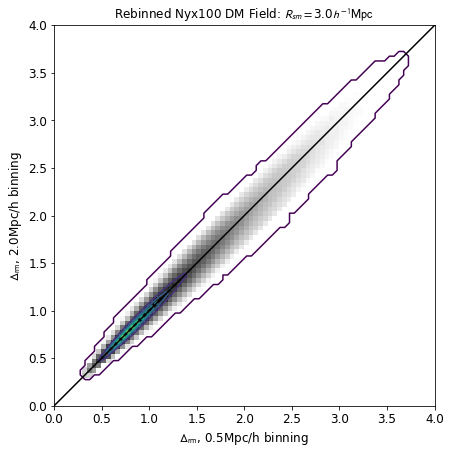

Pearson r-coefficient = 0.9902164966000284


In [5]:
# Look at scatter between 'native' 0.5Mpc/h binning and the rebinning from 2Mpc/h
bins_dm = np.arange(0, 4., 0.05)

hist2d_nyx, edges_nyx, edges_int = np.histogram2d(dm_nyx.flatten(), dm_int_arr.flatten(),
                                              bins=[bins_dm, bins_dm], density=True)

Xhist, Yhist = np.meshgrid(edges_nyx, edges_int)
XCon, YCon=np.meshgrid(edges_nyx[0:-1]+(edges_nyx[1]-edges_nyx[0])/2.,
                        edges_int[0:-1]+(edges_int[1]-edges_int[0])/2)

fig, ax = plt.subplots(figsize=(7,7))
ax.pcolormesh(Xhist, Yhist, np.transpose(hist2d_nyx), cmap='Greys',
             norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))
ax.contour(XCon,YCon, np.transpose(hist2d_nyx) )
ax.set_xlim(0., 4.)
ax.set_ylim(0., 4.)
tit_text1='Rebinned Nyx100 DM Field:'+r' $R_{sm}=$'+'{}'.format(gauss_sm)+r'$ h^{-1}\mathrm{Mpc}$'
ax.set_title(tit_text1)
ax.set_aspect('equal')
ax.set_xlabel(r'$\Delta_\mathrm{rm}$, 0.5Mpc/h binning')
ax.set_ylabel(r'$\Delta_\mathrm{rm}$, 2.0Mpc/h binning')

ax.plot([0., 4.], [0., 4.],color='black')

plt.show()
print('Pearson r-coefficient = {}'.format(stats.pearsonr(dm_nyx.flatten(), dm_int_arr.flatten())[0]))

Now, compare the BIRTH density field (1.875Mpc/h binning) with the Nyx DM field. We want to match the effective smoothing lengths.

First, compare the density PDF.

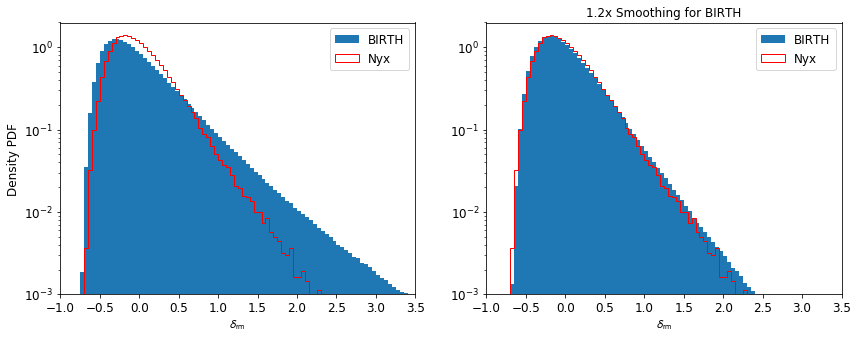

In [6]:
nc = 256
L = 480
dx_b = L/nc
file_in1 = '/Users/kheegan/lya/3d_recon/preheating/dmlcZ_1300.dat'

dmb = np.fromfile(file_in1,dtype=np.float32).reshape((nc,nc,nc))

sm_birth = np.sqrt(gauss_sm**2 - dx_b**2)
sm_tmp = np.sqrt(gauss_sm**2)*2.25/1.875   #Might this extra factor account for the excess in high densities?
dm_sm = ndimage.gaussian_filter(dmb, sm_tmp/dx_b, mode='wrap')
dm_sm2 = ndimage.gaussian_filter(dmb, sm_birth/dx_b, mode='wrap')

fig, (ax2,ax) = plt.subplots(1,2,figsize=(14,5))

ax.hist(dm_sm.flatten(), bins=np.arange(-1, 5., 0.05), density=True,log=True, 
        label='BIRTH')
ax.hist(dm_coarse.flatten()-1, bins=np.arange(-1, 5., 0.05), density=True, 
        color='red',log=True, label='Nyx',fill=False,histtype='step')

ax.set_ylim(1e-3, 2.)
ax.set_xlim(-1, 3.5)
ax.set_xlabel(r'$\delta_\mathrm{rm}$')
#ax.set_ylabel('Density PDF')
ax.set_title('1.2x Smoothing for BIRTH')
ax.legend()

ax2.hist(dm_sm2.flatten(), bins=np.arange(-1, 5., 0.05), density=True,log=True, 
        label='BIRTH')
ax2.hist(dm_coarse.flatten()-1, bins=np.arange(-1, 5., 0.05), density=True, 
        color='red',log=True, label='Nyx',fill=False,histtype='step')
ax2.set_ylim(1e-3, 2.)
ax2.set_xlim(-1, 3.5)
ax2.set_xlabel(r'$\delta_\mathrm{rm}$')
ax2.set_ylabel('Density PDF')
ax2.legend()

plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

"""Create k^2 in box (nc x nc x nc)"""
def ksquared(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.array(list(itertools.product(range(nc),repeat=3))) #nc x nc x nc combinations
    a = np.reshape(a,(nc,nc,nc,3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return k2


"""Function to calculate the auto power spectrum in spherical bins"""
def measure_pk(signal1,signal2, k,kbin, Lin, ncin):
    fsignal1 = np.fft.fft(signal1)
    fsignal2 = np.fft.fft(signal2)
    power = np.zeros(len(kbin))
    #xi, yi, zi = np.where(w>0) #3D index of win>0
    #divide k array into kbin
    for i in range(len(kbin[:-1])):
        xind,yind,zind = np.where((k>=kbin[i])*(k<kbin[i+1])) # 3D index of all k values at bin[i]
        power[i] = (np.abs(fsignal1[xind,yind,zind]*fsignal2[xind,yind,zind])).mean()*(L/nc**6) # add normalisation for comparison with theory
    return power

Nb = 100 # number of k-bins

k = np.sqrt(ksquared(nc,L)) 
kmin = 4.*np.pi/L
kmax = k.max()
kbin = np.linspace(kmin,kmax,Nb)

#signal1, signal2 are (nc,nc,nc) density fields
#for auto pk, signal1=signal2

signal1 = np.fromfile(file_in1,dtype=np.float32).reshape((nc,nc,nc))
signal2 = np.fromfile(file_in1,dtype=np.float32).reshape((nc,nc,nc))

pk_birth = measure_pk(signal1,signal2, k,kbin, L, nc)

dm_sm_copy = dm_sm.copy()
pk_birth_sm = measure_pk(dm_sm, dm_sm_copy, k, kbin, L, nc)

# Compute power spectrum for 2Mpc/h binned Nyx box
kk = np.sqrt(ksquared(nbincoarse, Lbox))
kkmin = 4.*np.pi/Lbox
kkmax = kk.max()
kkbin = np.linspace(kkmin,kkmax,50)

pk_nyx = measure_pk(dm_coarse-1, dm_coarse.copy()-1,kk,kkbin, Lbox, nbincoarse)
                                

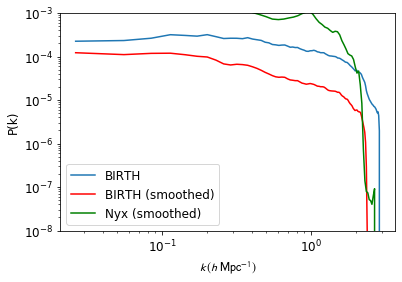

In [8]:
fig, ax = plt.subplots()

ax.plot(kbin, pk_birth, label='BIRTH')
ax.plot(kbin, pk_birth_sm, color='red',label='BIRTH (smoothed)')
ax.plot(kkbin, pk_nyx, color='green',label='Nyx (smoothed)')
ax.set_ylim(1e-8, 1e-3)
ax.set_ylabel(r'P(k)')
ax.set_xlabel(r'$k\; (h\; \mathrm{Mpc}^{-1})$')
ax.legend()

plt.yscale('log')
plt.xscale('log')
plt.show()


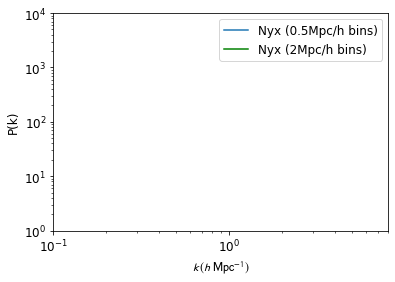

In [9]:
kkk = np.sqrt(ksquared(nbin, Lbox))
kkkbin = np.linspace(kkmin,kkk.max(),50)
pk_nyx2 = measure_pk(dm_nyx-1, dm_nyx.copy()-1,kkk,kkkbin, Lbox, nbin)

fig, ax = plt.subplots()

ax.plot(kkbin, pk_nyx2, label='Nyx (0.5Mpc/h bins)')
ax.plot(kkbin, pk_nyx, color='green',label='Nyx (2Mpc/h bins)')
ax.set_ylim(1, 1e4)
ax.set_xlim(0.1,8.)
ax.set_ylabel(r'P(k)')
ax.set_xlabel(r'$k\; (h\; \mathrm{Mpc}^{-1})$')
ax.legend()

plt.yscale('log')
plt.xscale('log')
plt.show()

In [10]:
print(pk_birth)

[2.25354839e-04 2.33825751e-04 2.64356952e-04 3.18276525e-04
 3.06360913e-04 2.94823861e-04 3.19074103e-04 2.86846427e-04
 2.60170981e-04 2.64062396e-04 2.63485609e-04 2.57955969e-04
 2.71864459e-04 2.53088318e-04 2.43771579e-04 2.35459828e-04
 2.13815989e-04 2.06910808e-04 1.89510172e-04 1.86076286e-04
 1.80662989e-04 1.83904763e-04 1.84601082e-04 1.74352041e-04
 1.64044834e-04 1.65863443e-04 1.61344917e-04 1.61850613e-04
 1.51922938e-04 1.45251787e-04 1.40143117e-04 1.33140443e-04
 1.31725047e-04 1.35925035e-04 1.36440923e-04 1.39530875e-04
 1.35462241e-04 1.28611509e-04 1.26645070e-04 1.22630766e-04
 1.22845394e-04 1.22427456e-04 1.15807444e-04 1.10880081e-04
 1.06164469e-04 1.03548570e-04 1.03129517e-04 1.02031231e-04
 1.00934469e-04 1.00147724e-04 9.74214469e-05 9.27461288e-05
 9.22233589e-05 9.03026334e-05 8.65043237e-05 8.29987239e-05
 8.03266313e-05 7.62366730e-05 7.39637471e-05 7.35588250e-05
 7.02976377e-05 6.63920139e-05 6.22941658e-05 5.94950229e-05
 5.65401965e-05 5.319249